## Testing chip.py

The Chip class uses a position list of three of the alignment marks on a chip to find a position list for the point to focus at (get_focus_position_list()) and the overall positon list to image the chip with (get_position_list()). The methods used to do this are described below. 

But first... The basics.

In [3]:
import sys
sys.path.insert(0, '../../source')

import chip
import position as pos
import numpy as np

In [4]:
# Create positions
sp1 = pos.StagePosition(x=0, y=10000, z=0) 
sp2 = pos.StagePosition(x=9500, y=9500, z=0) 
sp3 = pos.StagePosition(x=9000, y=-500, z=0)

pl = pos.PositionList(positions=[sp1, sp2, sp3])

In [5]:
mchip = chip.Chip(pl)
# Check that the positons were successfully reordered
print (mchip.corner_poslist)

(0,10000,0)
(9500,9500,0)
(9000,-500,0)



In [49]:
mchip.R

[[0.9986178293325096, 0.05255883312276367],
 [-0.05255883312276367, 0.9986178293325096]]

## Focus PositionList generation

Points are calculated by finding the rotation matrix of the chip in reference to the the x and y axes of the stage. This is done after the given points are reordered so that the bottom right point is concidered position 0. The rotation matrix is then calculated with: 

$$cos = \frac{corner\_pl[1].x - corner\_pl[0].x}{distacne(corner\_pl[1], corner\_pl[0])}$$

$$sin = \frac{corner\_pl[1].y - corner\_pl[0].x}{distacne(corner\_pl[1], corner\_pl[0])} $$ 

$$ R =
\begin{vmatrix}
cos&-sin\\
sin&cos\\
\end{vmatrix}
$$

We then use the distance between the corner points to find the dimentions of the chip. Using these dimentions, we construct a rectangle of points based on the parameters fp_x and fp_y. 

Then we rotate all of the calculated points to the rotation of the chip and append them to the list of focus positions using the formula:

$$\vec{x}_{rotated} = R\vec{x}_{calculated}$$

In [50]:
# Given params 
fp_x = 5
fp_y = 4

In [51]:
total_x = np.abs(mchip.corner_poslist[0].x
            - mchip.corner_poslist[1].x)
total_y = np.abs(mchip.corner_poslist[0].y 
           - mchip.corner_poslist[2].y)
delta_x = total_x / fp_x
delta_y = total_y / fp_y
print (total_x)
print (total_y)

9500
10500


In [52]:
origin = np.matmul(np.linalg.inv(mchip.R), 
                   [mchip.corner_poslist[0].x, mchip.corner_poslist[0].y])

fp_positions = pos.PositionList()
for y_ctr in range(fp_y):
    for x_ctr in range(fp_x):
        rotation = origin + [delta_x/2 + delta_x*x_ctr, 
                             -(delta_y/2 + delta_y*y_ctr)]
        fp = np.matmul(mchip.R, rotation)
        s = pos.StagePosition(x=fp[0], y=fp[1])
        fp_positions.append(s)

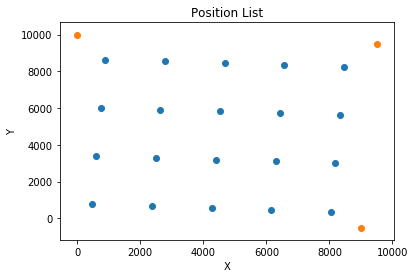

In [53]:
fp_positions.visualize(xy=True)
mchip.corner_poslist.visualize(xy=True)

## Total PositionList generation

The entire position list is generated in a very similar manner, but instead of using fp_x and fp_y to calculate the distance in-between points, we use the frame of the PVCAM. These are passed as arguments cam_frame_width and cam_frame_height. 

In [54]:
# Assume that focus works and all z=0
focused_pl = pos.PositionList()
for p in fp_positions:
    s = pos.StagePosition(x=p.x, y=p.y, z=0)
    focused_pl.append(s)

In [55]:
import focus
focus_func = focus.predict_z_height(focused_pl)


cam_frame_width = 1210.0 # PVCAM frame width
cam_frame_height = 990.0 # PVCAM frame height

x_steps = int(np.ceil(mchip.total_x/cam_frame_width))
y_steps = int(np.ceil(mchip.total_y/cam_frame_height))

In [56]:
origin = np.matmul(np.linalg.inv(mchip.R), 
                   [mchip.corner_poslist[0].x, mchip.corner_poslist[0].y])

In [57]:
positions = pos.PositionList()

for y_ctr in range(y_steps):
    for x_ctr in range(x_steps):
        rotation = origin + [cam_frame_width/2 + cam_frame_width*x_ctr, 
                             -(cam_frame_height/2 + cam_frame_height*y_ctr)]
        posit = np.matmul(mchip.R, rotation)
        s = pos.StagePosition(x=posit[0], y=posit[1])
        positions.append(s)

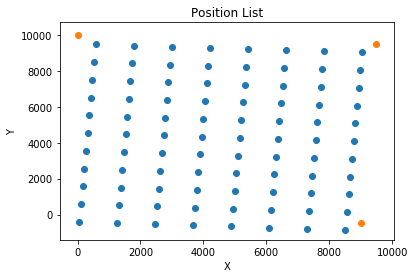

In [58]:
positions.visualize(xy=True)
mchip.corner_poslist.visualize(xy=True)

## Making sure that the actual functions work the same way

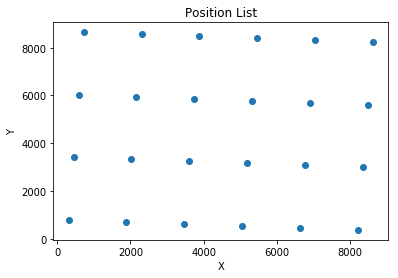

In [6]:
focus_pl = mchip.get_focus_position_list(6,4)
focus_pl.visualize(xy=True)

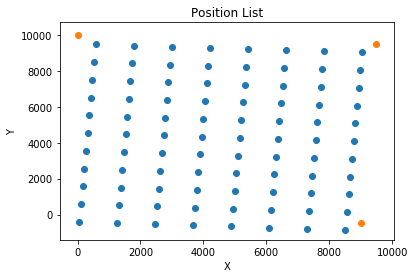

In [60]:
# Assume that focus works and all z=0
focused_pl = pos.PositionList()
for p in focus_pl:
    s = pos.StagePosition(x=p.x, y=p.y, z=0)
    focused_pl.append(s)

mchip.get_position_list(focused_pl).visualize(xy=True)
mchip.corner_poslist.visualize(xy=True)